<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-memowayun/blob/main/A01793695_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
## *Ciencia y Analítica de Datos*

### **Semana 7 -- Regresiones y K-means**


####**Curso: Ciencia y analítica de datos (Gpo 10)**

####**6 de Noviembre de 2022**


Nombre del estudiante: 

***Miguel Guillermo Galindo Orozco (A01793695)***


Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

# **Trabajo previo**

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 537 kB/s 
     |████████████████████████████████| 1.0 MB 3.7 MB/s 
     |████████████████████████████████| 1.7 MB 38.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 53.5 MB/s 
     |████████████████████████████████| 6.3 MB 48.0 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27813 sha256=9df6f231875c179557966127eecee3729692e7ae388785f8e643c20f7b5ce1d9
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=ea4c8d1b31388427114b3b7b7e3a760dc630fcc26c15a81b9a91cfba3c945163
  Stored in directory: /root/.c

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [6]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

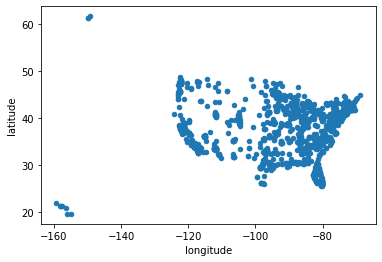

In [7]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [10]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [11]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [12]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

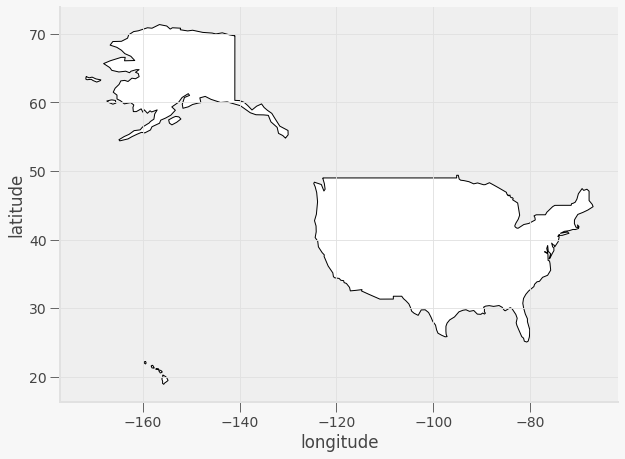

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

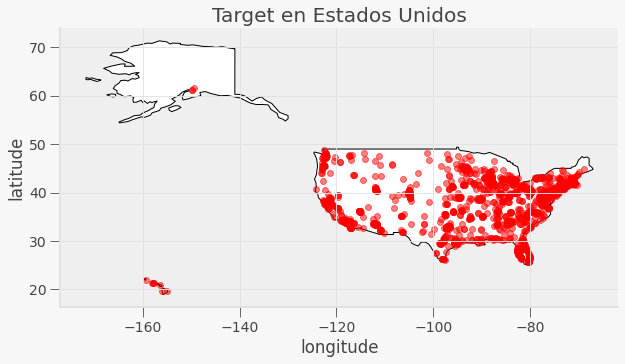

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

# **Primer intento de clustering con Kmeans (para probar funcionamiento del algoritmo)**

In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)

In [18]:
kmeans.fit(latlong)

KMeans(init='random', n_clusters=3, random_state=42)

In [19]:
kmeans.cluster_centers_

array([[  37.9827023 ,  -93.34747643],
       [  37.4817419 , -118.657146  ],
       [  37.789554  ,  -78.56990807]])

In [20]:
kmeans.labels_[:]

array([0, 0, 0, ..., 1, 0, 1], dtype=int32)

# **Encuentra el numero ideal de almacenes, justifica tu respuesta:**

**Buscar el número óptimo de clusters (y sus centroides) a utilizar**

# **¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.**

**Para esto hacemos uso del Silhouette Score como método para encontrar el número óptimo de clusters**

El Silhoutte Score es una métrica que permite: 

1. Medir la cercania de un registro con los demás dentro de su cluster. 

&
 
2. Medir la separación del mismo con otros registros que pertenecen a otros clusters.

De tal forma que, con esta métrica se permite optimizar el número de clusters totales que maximicen ambas métricas mencionadas. 

Puede tomar valores entre -1, y 1. A mayor valor, indica que ese número de clusters permite que el registro esté más cerca de los individuos de su cluster que de los individuos en otro cluster. 

In [21]:
from sklearn.metrics import silhouette_score

In [22]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

In [23]:
silhouette_coefficients = []

In [24]:
for k in range(2, 20):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(latlong)
  score = silhouette_score(latlong, kmeans.labels_)
  silhouette_coefficients.append(score)

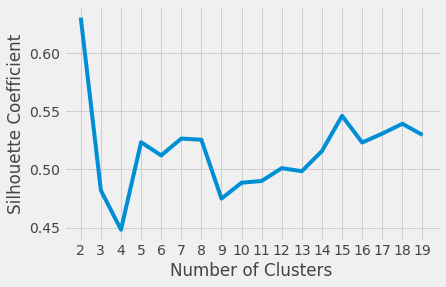

In [25]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

**Por otro lado, hago uso de una gráfica de codo como método complemtario para encontrar el número óptimo de clusters**

In [26]:
sse = []
for k in range(1, 20):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(latlong)
  sse.append(kmeans.inertia_)

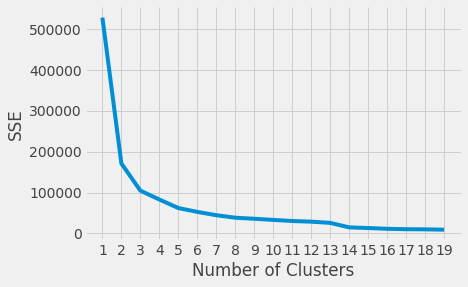

In [27]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# **Justifica tu respuesta técnicamente.**

**Con los datos anteriores, se decide que el número óptimo de clusters sea 5**

Ya que: 

- El Silhouette Score con 5 clusters es de 0.53 es alto, y sólo es superado  por 15 cluster con un silhouette Score de 0.55, salvo que de utilizar  15 centros de distribución que representarían un mayor costo para la empresa sin representar una ventaja real de la distancias implicada con cada centro de distribución. 

Por otro lado: 


- Observando la gráfica de codo, después de 5 clusters, aumentar más no representa una diminución significativa de la suma de distancia al centroide de cada cluster (SSE) p. 



# **Encuentra las latitudes y longitudes de los almacenes, ¿que ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estara?**

Con lo anterior obtenemos que: 

In [28]:
kmeans = KMeans(init="random",n_clusters=5,n_init=10,max_iter=300,random_state=42)
kmeans.fit(latlong)

KMeans(init='random', n_clusters=5, random_state=42)

Los Almacenes (centros de distribución), se encuentran en las siguientes latitudes y longuitudes: 

In [29]:
kmeans.cluster_centers_

array([[  34.42035677,  -98.26633716],
       [  37.57977424, -119.17634307],
       [  31.12170705,  -82.94636967],
       [  41.79018068,  -88.40362992],
       [  40.33790692,  -75.6259688 ]])

In [30]:
kmeans.cluster_centers_[0][0]

34.42035677094595

Generamos el siguiente DataFrame que resume los resultados (cluster, centroides y distancias a cluster asignado) para cada observación

In [31]:
clusters = kmeans.predict(latlong)
clusters

array([2, 2, 2, ..., 0, 0, 1], dtype=int32)

In [32]:
data_with_clusters = latlong.copy()
data_with_clusters['Clusters'] = clusters
data_with_clusters['Latitude_Centroide'] = np.select(
    [
      (data_with_clusters['Clusters'] == 0),
      (data_with_clusters['Clusters'] == 1),
      (data_with_clusters['Clusters'] == 2),
      (data_with_clusters['Clusters'] == 3),
      (data_with_clusters['Clusters'] == 4)
    ], 
    [
      kmeans.cluster_centers_[0][0],
      kmeans.cluster_centers_[1][0],
      kmeans.cluster_centers_[2][0],
      kmeans.cluster_centers_[3][0],
      kmeans.cluster_centers_[4][0],
    ],
    default=0
    )

data_with_clusters['Longitude_Centroide'] = np.select(
    [
      (data_with_clusters['Clusters'] == 0),
      (data_with_clusters['Clusters'] == 1),
      (data_with_clusters['Clusters'] == 2),
      (data_with_clusters['Clusters'] == 3),
      (data_with_clusters['Clusters'] == 4)
    ], 
    [
      kmeans.cluster_centers_[0][1],
      kmeans.cluster_centers_[1][1],
      kmeans.cluster_centers_[2][1],
      kmeans.cluster_centers_[3][1],
      kmeans.cluster_centers_[4][1],
    ],
    default=0
    )

#data_with_clusters['Distancia_Euclideana_Centroide'] = np.sqrt((data_with_clusters['latitude']-data_with_clusters['Latitude_Centroide'])**2+(data_with_clusters['longitude']-data_with_clusters['Longitude_Centroide'])**2)

In [33]:
### Distancia Haversine (Semiverseno) para distancia entre dos coordenadas (tomada de referencia 3)
r = 6371        

data_with_clusters['Distancia_Haversine'] = r*np.multiply(2, np.arcsin(np.sqrt(np.add(np.power(np.sin(np.divide((data_with_clusters['latitude']-data_with_clusters['Latitude_Centroide']), 2)), 2),
            np.multiply(np.cos(data_with_clusters['Latitude_Centroide']),
                        np.multiply(np.cos(data_with_clusters['latitude']),
                                    np.power(np.sin(np.divide((data_with_clusters['longitude']-data_with_clusters['Longitude_Centroide']), 2)), 2))
                        )
          ))))


In [34]:
data_with_clusters

,latitude,longitude,Clusters,Latitude_Centroide,Longitude_Centroide,Distancia_Haversine
0,33.224225,-86.804174,2,31.121707,-82.946370,10722.660763
1,33.334550,-86.989778,2,31.121707,-82.946370,10455.899231
2,30.602875,-87.895932,2,31.121707,-82.946370,7625.829359
3,34.560148,-86.971559,2,31.121707,-82.946370,5844.850262
4,31.266061,-85.446422,2,31.121707,-82.946370,15081.522553
...,...,...,...,...,...,...
1834,43.034293,-88.176840,3,41.790181,-88.403630,7867.663363
1835,42.989604,-88.259806,3,41.790181,-88.403630,7619.053842
1836,42.846799,-106.264166,0,34.420357,-98.266337,10416.207990
1837,41.162019,-104.800048,0,34.420357,-98.266337,3318.471944


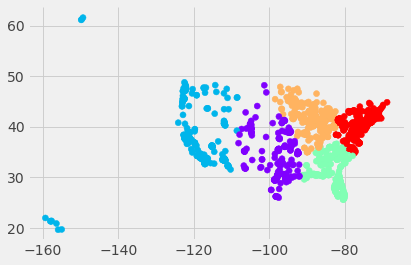

In [35]:
plt.scatter(data_with_clusters['longitude'],data_with_clusters['latitude'],c=data_with_clusters['Clusters'],cmap='rainbow')

## **Siendo las siguintes ciudades:**

#### **Almacen 1:**

**¿Qué ciudad es?**

Ubicación

In [36]:
df[(df['latitude']>=(kmeans.cluster_centers_[0][0])) & (df['latitude']<(kmeans.cluster_centers_[0][0]+0.5)) & (df['longitude']<=(kmeans.cluster_centers_[0][1])) & (df['longitude']>(kmeans.cluster_centers_[0][1]-1))]

,name,latitude,longitude,address,phone,website,Coordinates
1345,Lawton,34.629866,-98.495394,"2030 NW 82nd Street, Lawton, OK 73505-2355",580-354-7274,https://www.target.com/sl/lawton/2739,POINT (-98.49539 34.62987)


Ciudad Lawton que pertenece a Oklahoma City.

**¿ A cuántas ciudades va a surtir?**

In [37]:
almacen_1 = data_with_clusters[data_with_clusters['Clusters']==0]
len(almacen_1)

296

**¿A qué distancia estará?**

El promedio de la distancia en metros del almacen a las ciudades

In [38]:
np.mean(almacen_1['Distancia_Haversine'])

9537.063655312699

#### **Almacen 2:**

**¿Qué ciudad es?**

Ubicación

In [39]:
df[(df['latitude']>=(kmeans.cluster_centers_[1][0])) & (df['latitude']<(kmeans.cluster_centers_[1][0]+1.9)) & (df['longitude']<=(kmeans.cluster_centers_[1][1])) & (df['longitude']>(kmeans.cluster_centers_[1][1]-1))]

,name,latitude,longitude,address,phone,website,Coordinates
1036,Carson City,39.099892,-119.778251,"910 Jacks Valley Rd, Carson City, NV 89705-6936",775-267-5151,https://www.target.com/sl/carson-city/1239,POINT (-119.77825 39.09989)
1038,Reno South,39.463054,-119.780422,"6845 Sierra Center Pkwy, Reno, NV 89511-2214",775-853-8900,https://www.target.com/sl/reno-south/1363,POINT (-119.78042 39.46305)


Ciudad Carson que pertenece a Nevada.

**¿ A cuántas ciudades va a surtir?**

In [40]:
almacen_2 = data_with_clusters[data_with_clusters['Clusters']==1]
len(almacen_2)

368

**¿A qué distancia estará?**

El promedio de la distancia en metros del almacen a las ciudades

In [41]:
np.mean(almacen_2['Distancia_Haversine'])

11613.990613310423

#### **Almacen 3:**

**¿Qué ciudad es?**

Ubicación

In [42]:
df[(df['latitude']>=(kmeans.cluster_centers_[2][0])) & (df['latitude']<(kmeans.cluster_centers_[2][0]+1.9)) & (df['longitude']<=(kmeans.cluster_centers_[2][1])) & (df['longitude']>(kmeans.cluster_centers_[2][1]-1))]

,name,latitude,longitude,address,phone,website,Coordinates
512,Warner Robins,32.61629,-83.685866,"2929 Watson Blvd, Warner Robins, GA 31093-9600",478-971-2141,https://www.target.com/sl/warner-robins/1380,POINT (-83.68587 32.61629)


Ciudad Warner Robins que pertenece a Georgia.

**¿ A cuántas ciudades va a surtir?**

In [43]:
almacen_3 = data_with_clusters[data_with_clusters['Clusters']==2]
len(almacen_3)

274

**¿A qué distancia estará?**

El promedio de la distancia en metros del almacen a las ciudades

In [44]:
np.mean(almacen_3['Distancia_Haversine'])

10895.57662337712

#### **Almacen 4:**

**¿Qué ciudad es?**

Ubicación

In [45]:
df[(df['latitude']>=(kmeans.cluster_centers_[3][0])) & (df['latitude']<(kmeans.cluster_centers_[3][0]+0.2)) & (df['longitude']<=(kmeans.cluster_centers_[3][1])) & (df['longitude']>(kmeans.cluster_centers_[3][1]-1))]

,name,latitude,longitude,address,phone,website,Coordinates
554,DeKalb,41.955836,-88.725189,"2555 Sycamore Rd, Dekalb, IL 60115-2051",815-787-6970,https://www.target.com/sl/dekalb/2559,POINT (-88.72519 41.95584)


Ciudad DeKalb Robins que pertenece a Chicago.

**¿ A cuántas ciudades va a surtir?**

In [46]:
almacen_4 = data_with_clusters[data_with_clusters['Clusters']==3]
len(almacen_4)

419

**¿A qué distancia estará?**

El promedio de la distancia en metros del almacen a las ciudades

In [47]:
np.mean(almacen_4['Distancia_Haversine'])

8620.688738986717

#### **Almacen 5:**

**¿Qué ciudad es?**

Ubicación

In [48]:
df[(df['latitude']>=(kmeans.cluster_centers_[4][0])) & (df['latitude']<(kmeans.cluster_centers_[4][0]+0.2)) & (df['longitude']<=(kmeans.cluster_centers_[4][1])) & (df['longitude']>(kmeans.cluster_centers_[4][1]-1))]

,name,latitude,longitude,address,phone,website,Coordinates
1415,Muhlenberg Township,40.397834,-75.929449,"4220 N 5th Street Hwy, Temple, PA 19560-1738",610-921-5140,https://www.target.com/sl/muhlenberg-township/...,POINT (-75.92945 40.39783)
1424,Spring Township,40.360123,-75.983514,"2769 Papermill Rd, Wyomissing, PA 19610-3329",610-374-9875,https://www.target.com/sl/spring-township/1222,POINT (-75.98351 40.36012)


Ciudad Muhlenberg Township que pertenece Temple.

**¿ A cuántas ciudades va a surtir?**

In [49]:
almacen_5 = data_with_clusters[data_with_clusters['Clusters']==4]
len(almacen_5)

482

**¿A qué distancia estará?**

El promedio de la distancia en metros del almacen a las ciudades

In [50]:
np.mean(almacen_5['Distancia_Haversine'])

9725.880500432684

**Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.**

# **¿Qué librerías nos pueden ayudar a graficar este tipo de datos?**

- Geopandas -- Librería complementaria a pandas que permite graficar mapas desde un dataframe

- Basemap -- paquetería de funciones dentro de matplotlib 

- Cartopy -- Nueva versión de Basemap que permite cálculos geoespaciales así como gráficas de mapas


# **¿Consideras importante que se grafique en un mapa?, ¿por qué?**

Si, lo considero importante ya que de esta manera permite realizar un análisis descriptivo de los datos, y entender de mejor manera el contexto. 

Lo cuál desde mi experiencia, al tener mejor entendimiento de los datos, te brinda mejores herramientas para aproximar el problema, lo cuál optimiza el tiempo de la solución, así como la calidad de la misma.

# **Conclusiones**

El problema anterior, refleja la realidad de un problema de logística en el mundo de negocios, del cual se propone una solución con agrupamineto de observaciones (clustering) que permita optimizar el número mínimo de almacenes generales que disminuya la distancia entre ciudades dónde se distribuirán sus productos. 

Con lo aprendido en este problema, no sólo se entiende como abordar un problema de esta tipología, sino conocer el trasfondo de las herramientas que permite atacar distintas problemáticas de agrupamientos, tales como agrupar comportamiento de personas en su consumo, asignación de almacenes, entendimiento de características por enfermedades, etc. 

Adicionalmente, existen herramientas técincas como la gráfica de codo, o el Silhouette Score, que reflejan una métrica para seleccionar el número de clusters que optimice la distancia entre individuos de la muestra con los centroides a los que pertencen. Dónde la distancia no sólo se refiere a distancia en metros entre dos puntos, sino en similitudes y diferencias entre características de individuos. 

## **Referencias**

Capítulo 9-> Unsupervised Learning Techniques -> K means

https://github.com/ageron/handson-ml3/blob/main/09_unsupervised_learning.ipynb

https://realpython.com/k-means-clustering-python/

https://es.stackoverflow.com/questions/511284/como-hallar-la-distancia-en-kilomestros-entre-dos-coordenadas-en-python

-- Fin de la actividad --